***
# DSCI 100: Group Project Proposal
## Generation and Assessment Classification Model for Secondary Student's Alcohol Consumption 

#### **Section 006 - Group 6**
#### Authors: Duncan Harrop, Julia Sangster, Charisse Webb, Janelle Xie
***

## **Introduction**
***

Excessive alcohol consumption has been related to poor school performance and engagement in university and secondary-schools [2, 3]. To address this, there are frequently studies to measure alcohol consumption at education institutions. These primarily rely on large-scale surveys of students self-reporting alcohol consumption. The aim of this project is to find statistics that are non self-reported that can classify the alcohol consumption severity of a student. 

In 2008, a researcher collected data from two Portuguese secondary schools via mark reports and questionnaires [1]. As part of this study, the researchers had the students rate their weekday (`Dalc`) and weekend (`Walc`) alcohol consumption. The goal of collecting this dataset was to predict students final marks using various social factors. The dataset will be repurposed for our analysis and to answer the following question.

Can the non-self-reported statistics (age, grades, sex, failures, number of absences) of a student be used to accurately classify the severity of a student's level of weekly alcohol consumption on a scale of 2 - 10?

***
## **Preliminary Exploratory Data Analysis**
***

#### Notebook Setup

In [8]:
## This cell does all set-up steps for analysis 

## NOTE: Uncomment these lines if you do not have tidyverse, repr or tidymodels package installed
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("tidymodels")

## The following lines load all relevant packages for analysis
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(tidymodels))

## Reducing default table output size 
options(repr.matrix.max.rows = 6)
    
## Setting the RNG seed for analysis
set.seed(9999)

## Setting theme for output
theme_set(theme_bw())

#### Reading Data from Web Repository

The cell below loads the raw dataset from the repository.

In [9]:
## Note: Data was stored in .zip file so read_csv() was not working from a path to Kaggle
## This change was approved March-02-2022 by TA Shruti

suppressWarnings({
      
    ## Reading file from GitHub project repository
    student_alcohol_consumption_raw <- read_csv("https://raw.githubusercontent.com/juliasangster/DSCI_Project/main/data/student-mat.csv", col_types = cols())
    
    ## Displaying a part of the loaded data
    head(student_alcohol_consumption_raw)
    })

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


#### Cleaning/Wrangling Data:

The raw dataset contains no `NA` values, as shown below.

In [10]:
number_observations_total <- nrow(student_alcohol_consumption_raw)

data_na <- student_alcohol_consumption_raw |>
    filter_if(is.numeric, any_vars(is.na(.)))

number_rows_containing_na <- nrow(data_na)

if(is.null(data_na)) {
    number_rows_containing_na = 0}


print("The total number of rows is:")
print(number_observations_total)
print("The number of rows containing NA values is:")
print(number_rows_containing_na)


[1] "The total number of rows is:"
[1] 395
[1] "The number of rows containing NA values is:"
[1] 0


The following wrangling steps were then conducted
1. Selected relevant columns for preliminary analysis
2. Created a `Talc` column as the sum of `Dalc` and `Walc`
3. Calculated and stored the average of academic assessments in column `AvgG`
4. Converted discrete variables sex, Talc, and failures to fct data type
5. Selected relevant columns for final analysis

These steps are contained in the cells that follow.

In [4]:
## Select relevant columns for preliminary analysis
student_alcohol_consumption <- student_alcohol_consumption_raw |>
    select(sex, age, failures, Dalc, Walc, absences, G1, G2, G3)

In [5]:
## Convert weekend and weekday alcohol consumption to weekly total alcohol consumption 
student_alcohol_consumption <- student_alcohol_consumption |>
    mutate(Talc = Dalc + Walc) 

In [6]:
## Convert individual grade assessments to average grade assessment 
student_alcohol_consumption <- student_alcohol_consumption |>
    mutate(AvgG = (G1 + G2 + G3)/3)

In [13]:
## Convert discrete variables to factor type 
student_alcohol_consumption$Talc <- as.factor(student_alcohol_consumption$Talc)
student_alcohol_consumption$failures <- as.factor(student_alcohol_consumption$failures)
student_alcohol_consumption$sex <- as.factor(student_alcohol_consumption$sex)

In [14]:
## Select relevant columns for final analysis
student_alcohol_consumption <- student_alcohol_consumption |>
    select(-Dalc, - Walc, -G1, -G2, -G3) 

The dataset was then split into training (75%) and testing (25%) data-sets.

In [16]:
## Splitting data into testing/training data frames
sac_split <- initial_split(student_alcohol_consumption, 
                            prop = 0.75,
                            strata = Talc)

## Grabbing the training set in a single data frame
sac_train <- training(sac_split)

## Grabbing the testing set in a single data frame
sac_test  <- testing(sac_split)

## If you would like to see the indivdual training/testing sets, please uncomment the lines below 
sac_split

<Training/Testing/Total>
<294/101/395>

The next section will focus on describing our wrangled training dataset, which prints partially below.

In [19]:
head(sac_train)

sex,age,failures,absences,Talc,AvgG
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>
F,18,0,6,2,5.666667
F,17,0,4,2,5.333333
M,16,0,0,2,11.666667
F,17,0,6,2,5.666667
M,15,0,0,2,17.666667
M,15,0,0,2,15.333333


#### Summarizing and Visualizing Training Data 

In the analysis to be conducted, the predictors are `age`, `sex`, `failures`, `absences`, and `AvgG`

The response variable will be the total weekly alcohol consumption `Talc`.

The relation between these variables will be discussed below.

##### Investigating Total Weekly Alcohol Consumption in Training Data

A distribution of `Talc` in the training set was created.

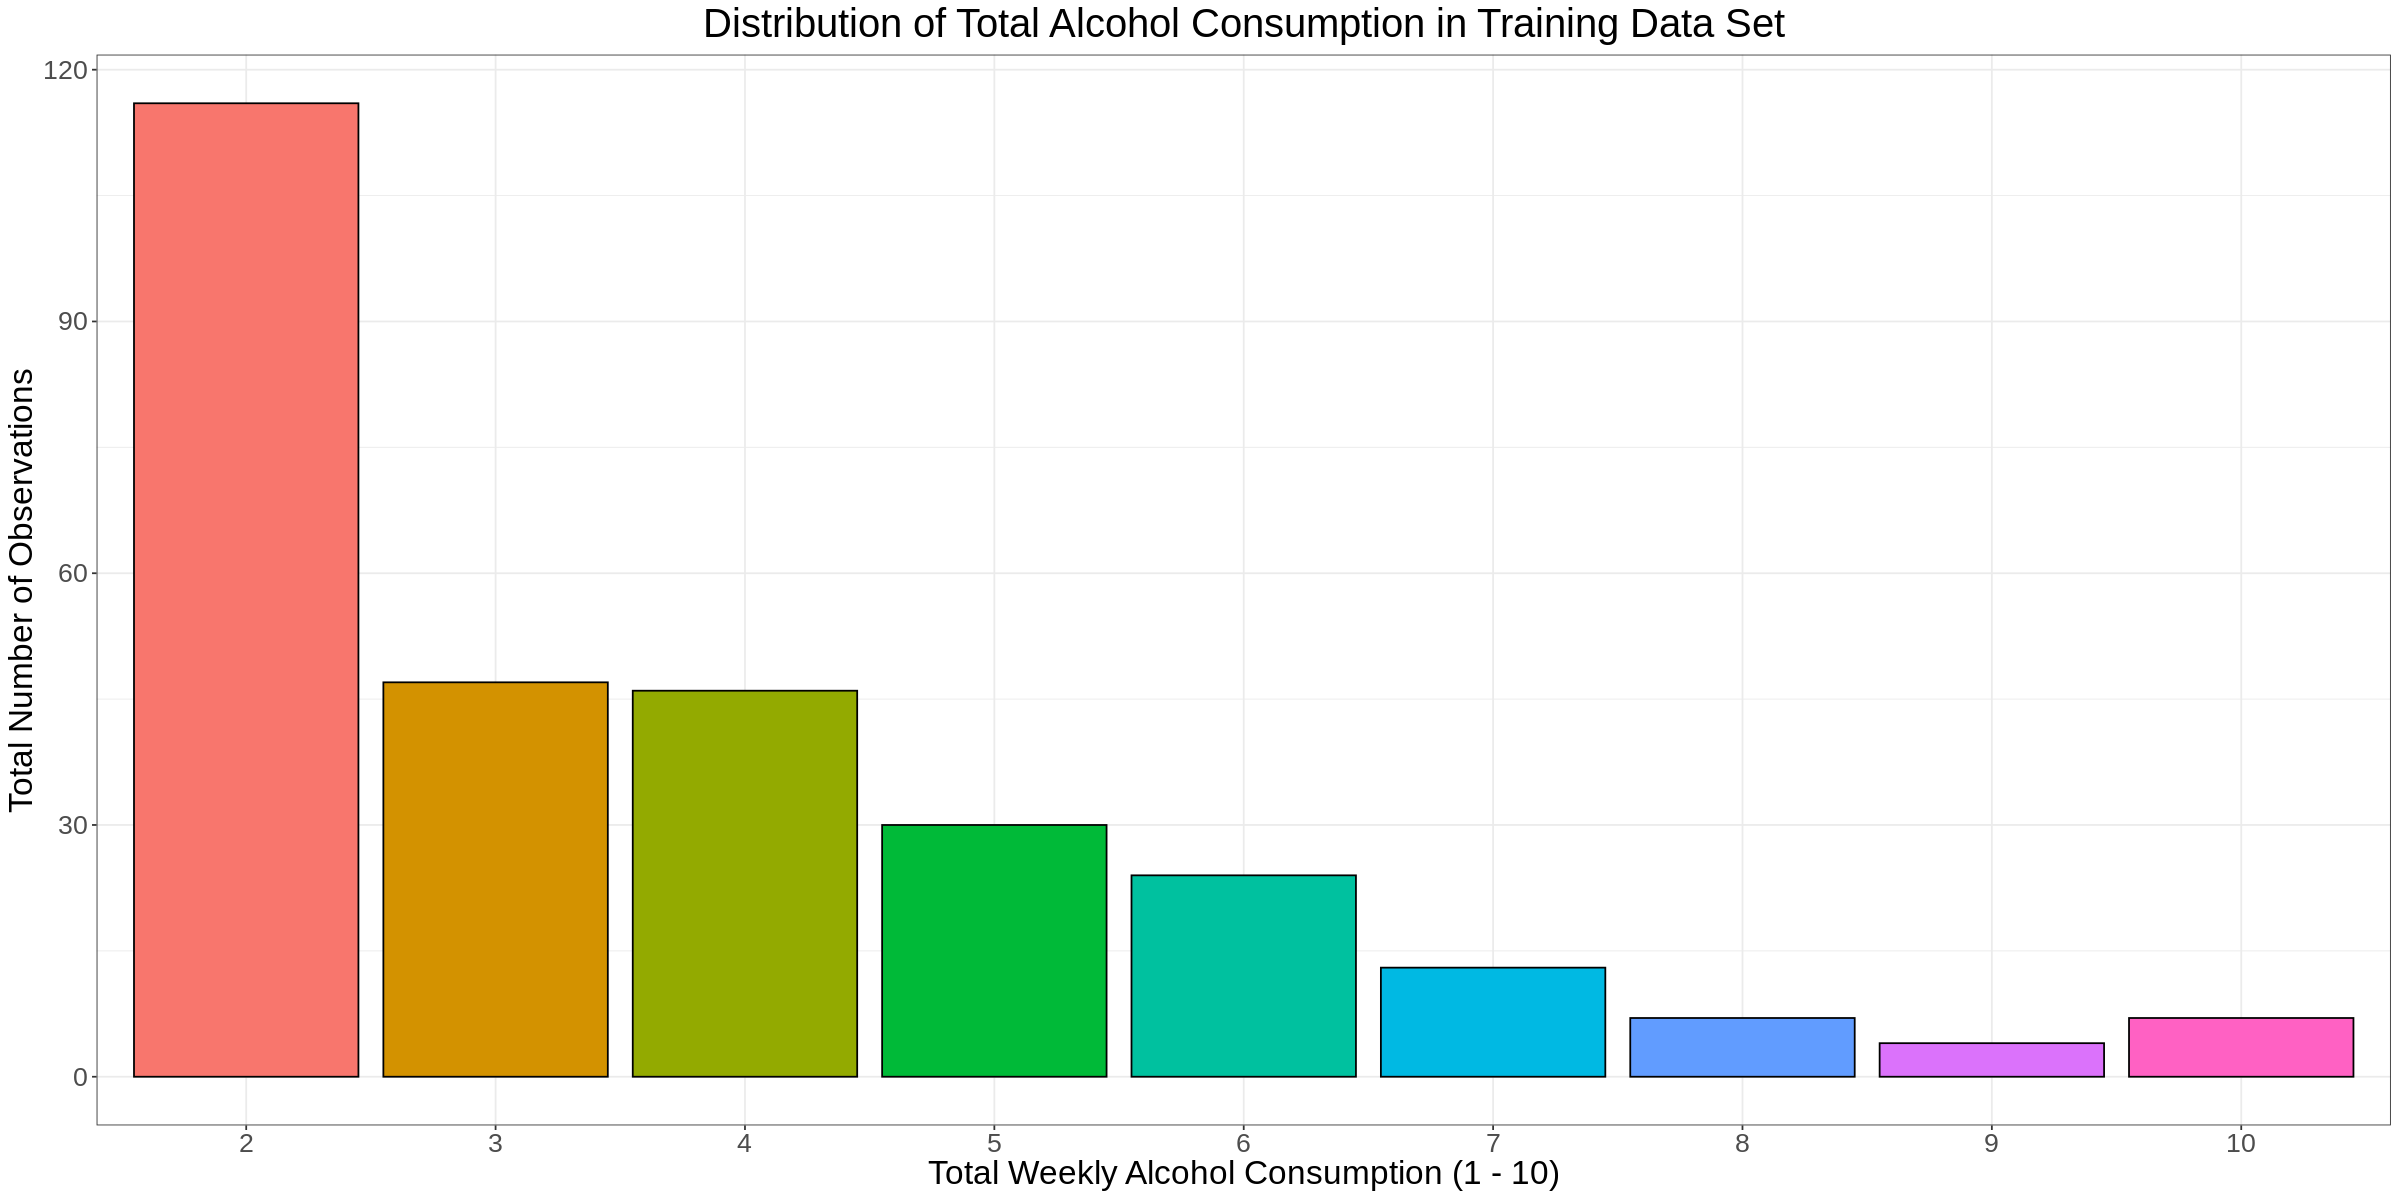

In [30]:
alcohol_consump_data <- sac_train |>
    select(Talc) 

options(repr.plot.width = 20, repr.plot.height = 10) 

suppressWarnings({
alcohol_consump_plot <- alcohol_consump_data |>
    ggplot(aes(x = Talc)) +
    geom_histogram(aes(fill = Talc), color = "black", stat = "count") +
    xlab("Total Weekly Alcohol Consumption (1 - 10)") +
    ylab("Total Number of Observations") +
    ggtitle("Distribution of Total Alcohol Consumption in Training Data Set") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size = 20),
         legend.position = "none")
})

alcohol_consump_plot

The distribution is right-skewed, with more observations in lower `Talc` levels.

##### Sex Distribution 

The relationship between `sex` and `Talc` distribution was investigated.

`summarise()` has grouped output by 'Talc'. You can override using the
`.groups` argument.


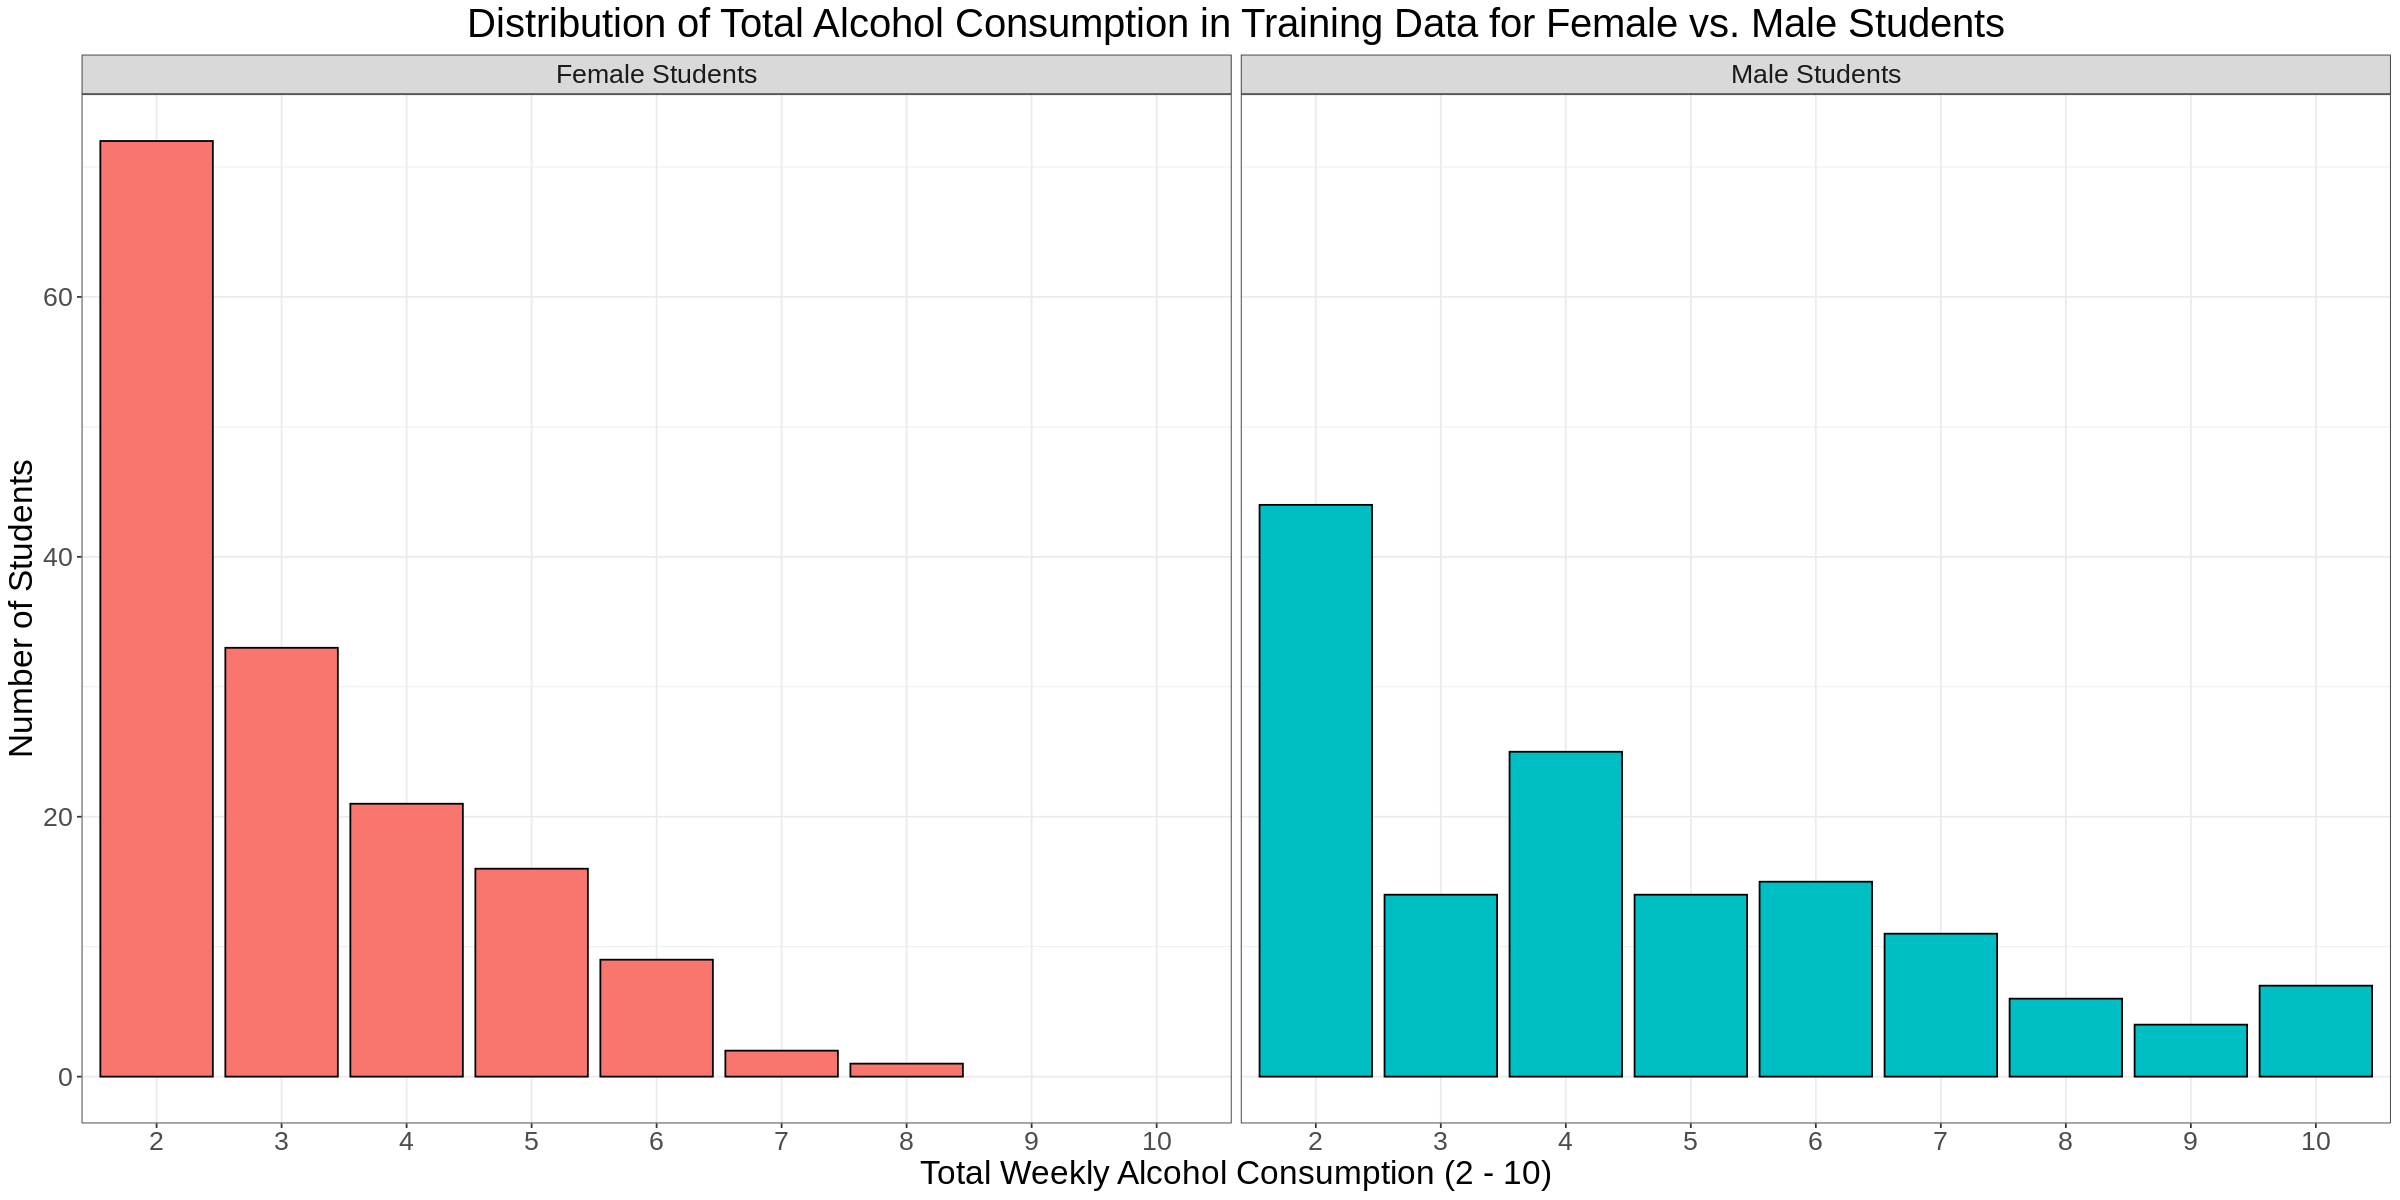

In [65]:
sac_train_sex_distribution_chart_data <- sac_train |>
    select(Talc, sex) |>
    group_by(Talc, sex) |>
    summarize(count = n())

## Code for plot: 
options(repr.plot.width = 20, repr.plot.height = 10) 
sac_train_sex_distribution_chart_data$sex <- factor(sac_train_sex_distribution_chart_data$sex, levels = c("F","M"),
                                                    labels = c("Female Students", "Male Students"))
sac_train_sex_distribution_chart <- sac_train_sex_distribution_chart_data |>
     ggplot(aes(x = Talc, y = count, fill = sex)) + 
     geom_bar(stat = "identity",
             color = "black") +
     facet_grid(cols = vars(sex)) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Number of Students",
          title = "Distribution of Total Alcohol Consumption in Training Data for Female vs. Male Students") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20),
           legend.position = "none")


sac_train_sex_distribution_chart

Visually, it appears male students have higher average `Talc`

##### Age Distribution

The relationship between `Talc` and `age` distribution was investigated.

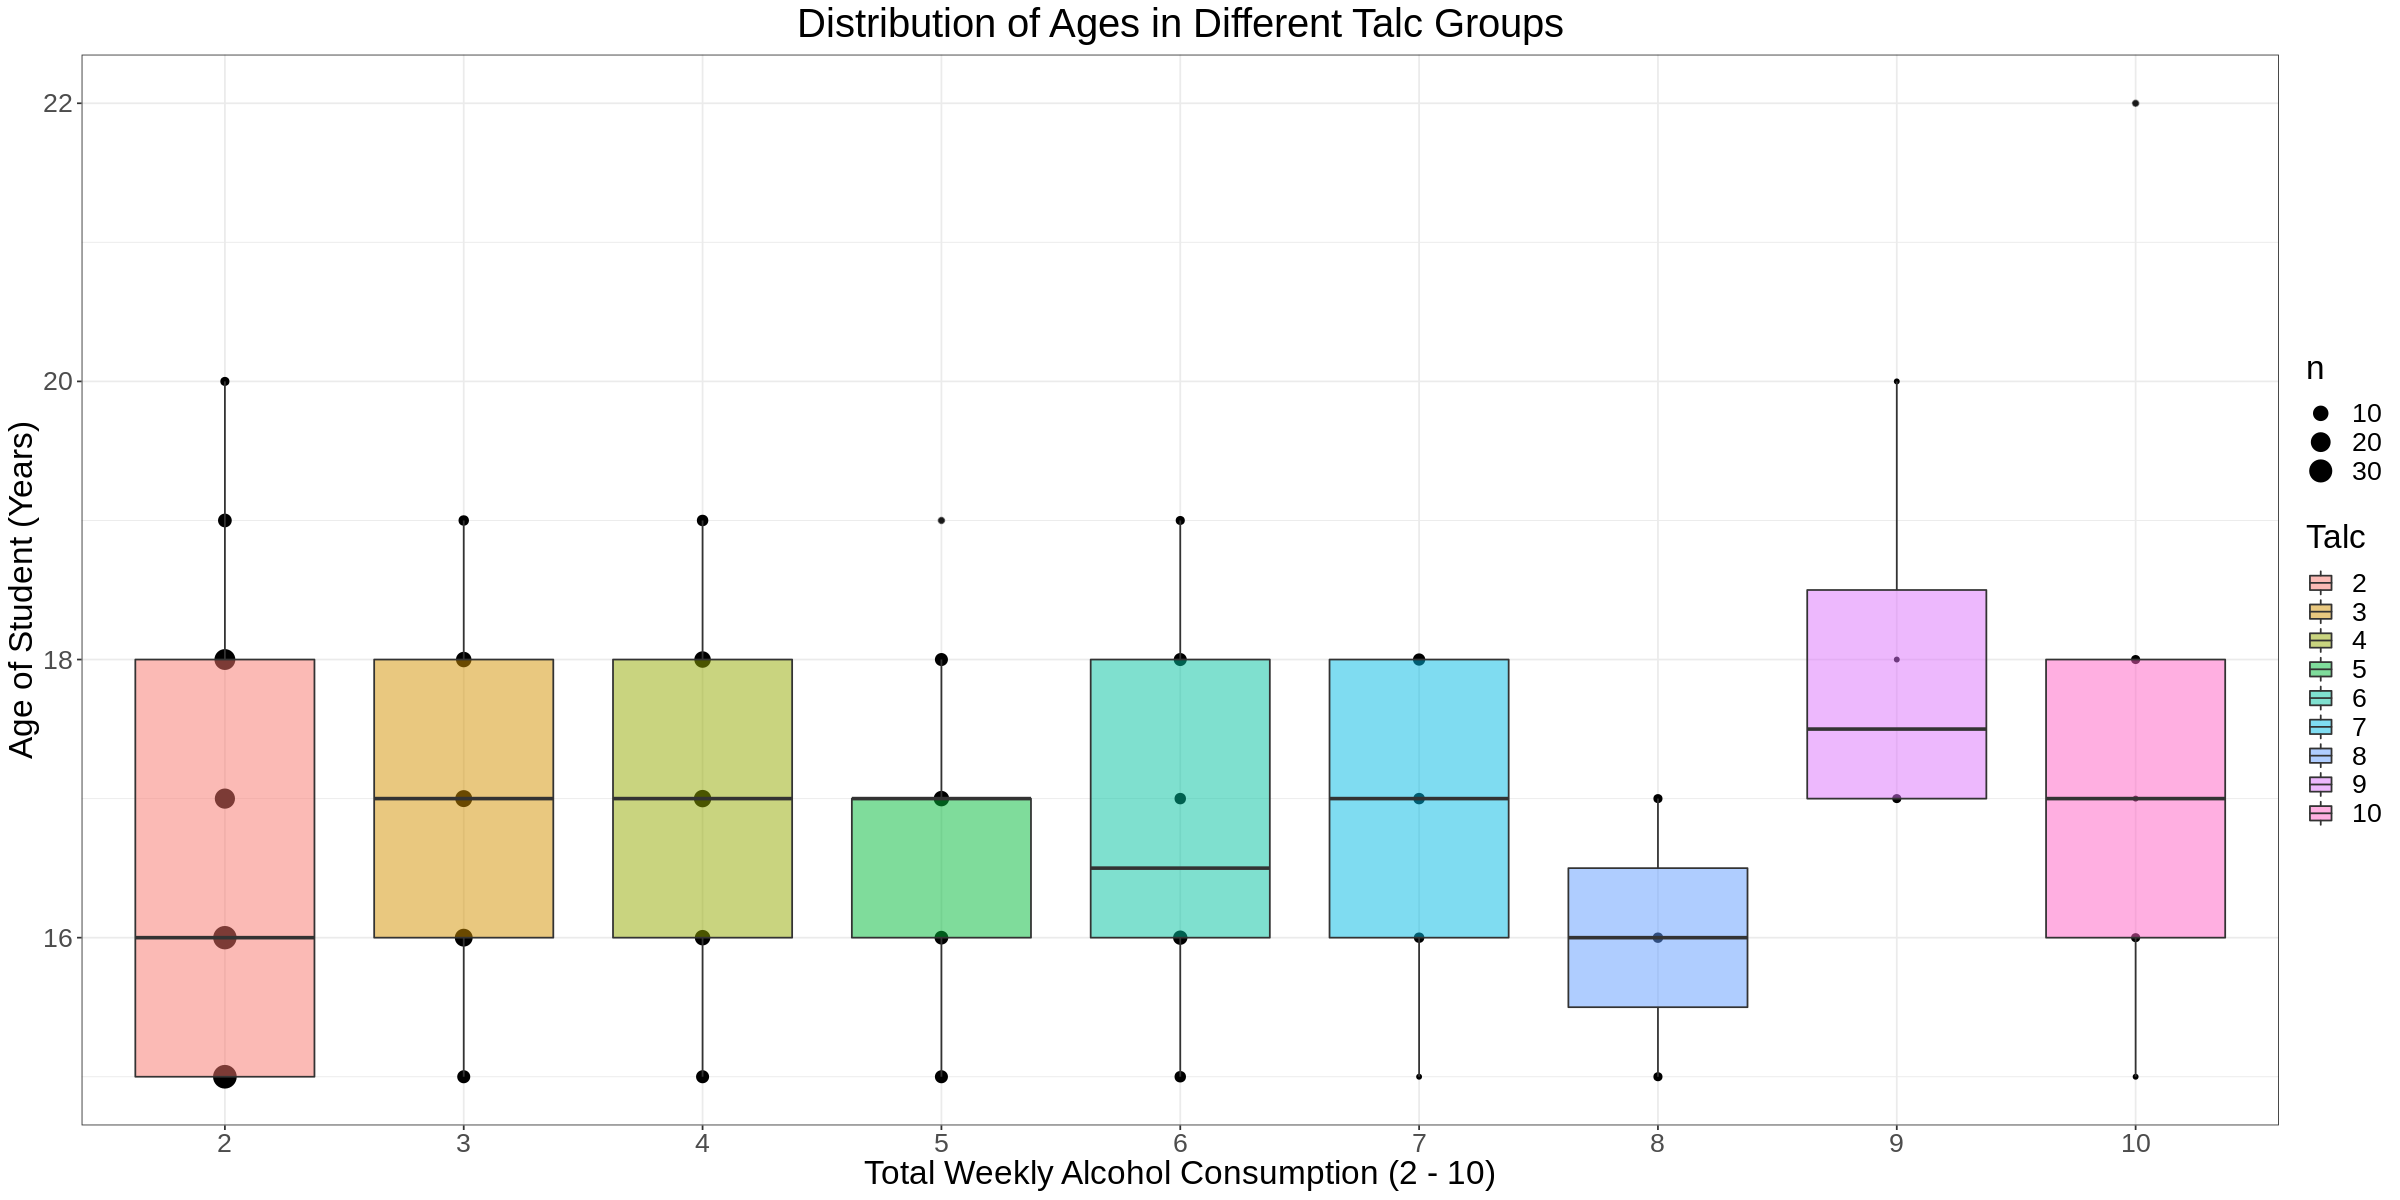

In [67]:
sac_train_age_bar_chart_data <- sac_train |>
    select(Talc, age)

options(repr.plot.width = 20, repr.plot.height = 10) 
sac_train_age_bar_chart <- sac_train_age_bar_chart_data |>
     ggplot(aes(x = Talc, y = age)) + 
     geom_count(aes(x = Talc, y = age)) +
     geom_boxplot(aes(fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Age of Student (Years)",
          title = "Distribution of Ages in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))


sac_train_age_bar_chart

It appears generally, students in the lowest `Talc` group are younger.

##### Absences Distribution 

The relationship between `Talc` and `absences` distribution was investigated.

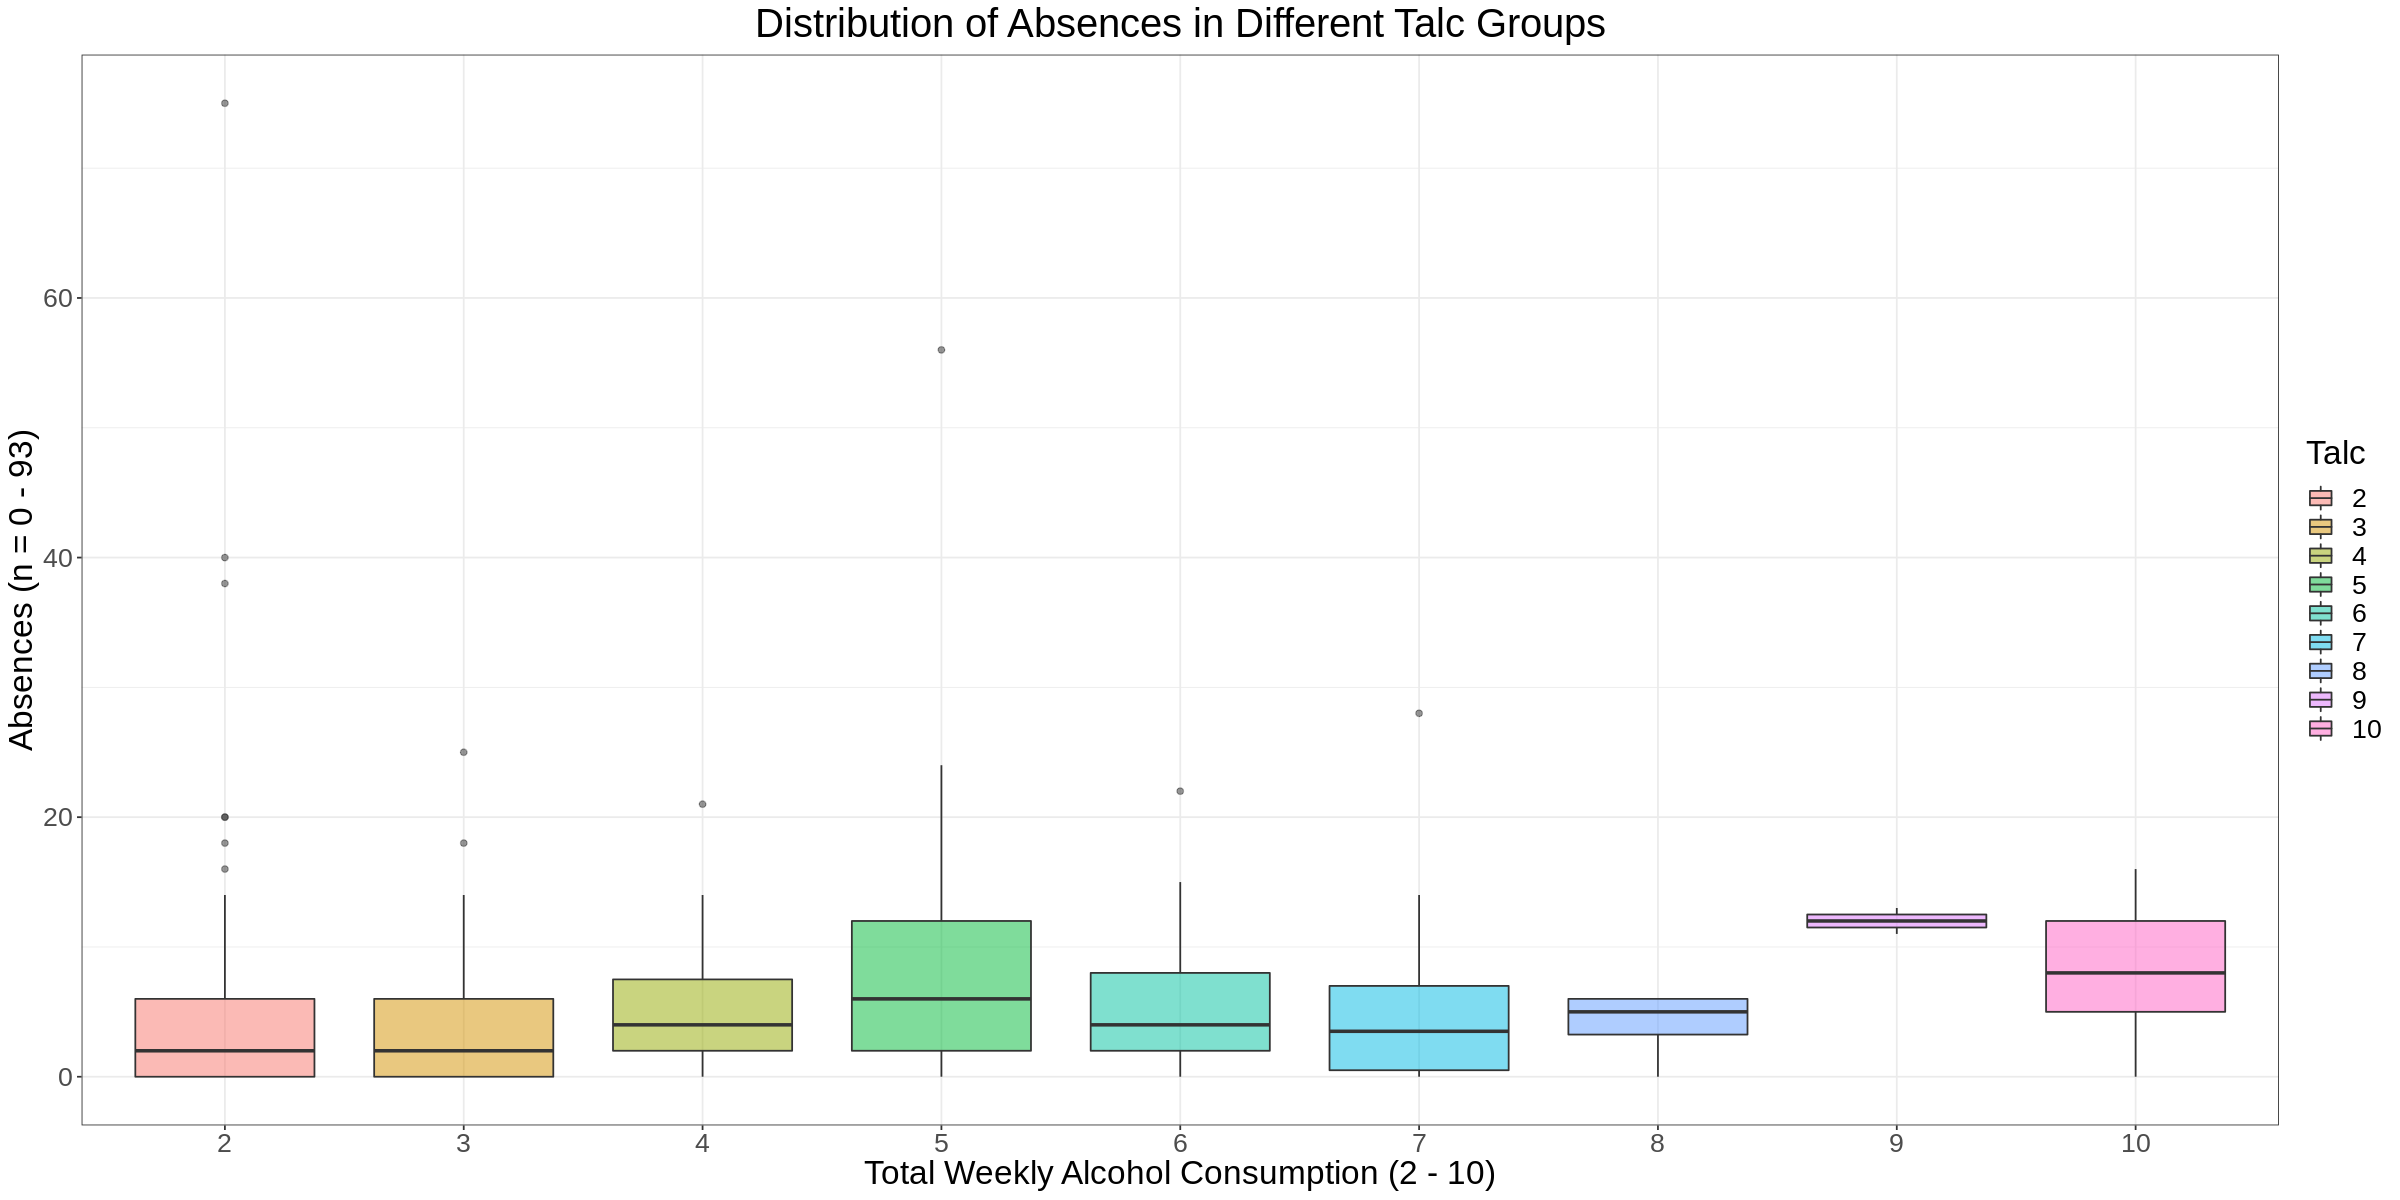

In [127]:
sac_train_absences_scatter_data <- sac_train |>
    select(Talc, absences)

sac_train_abscences_plot <- sac_train_absences_scatter_data |>
    ggplot() +
    geom_count(aes(x = Talc, y = absences)) +
    geom_boxplot(aes(x = Talc, y = absences, fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Absences (n = 0 - 93)",
          title = "Distribution of Absences in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))


sac_train_abscences_plot

Again, there is a slight trend of more absences in higher `Talc` groups.

##### Failures Distribution

The relationship between `Talc` and `failures` distribution was investigated.

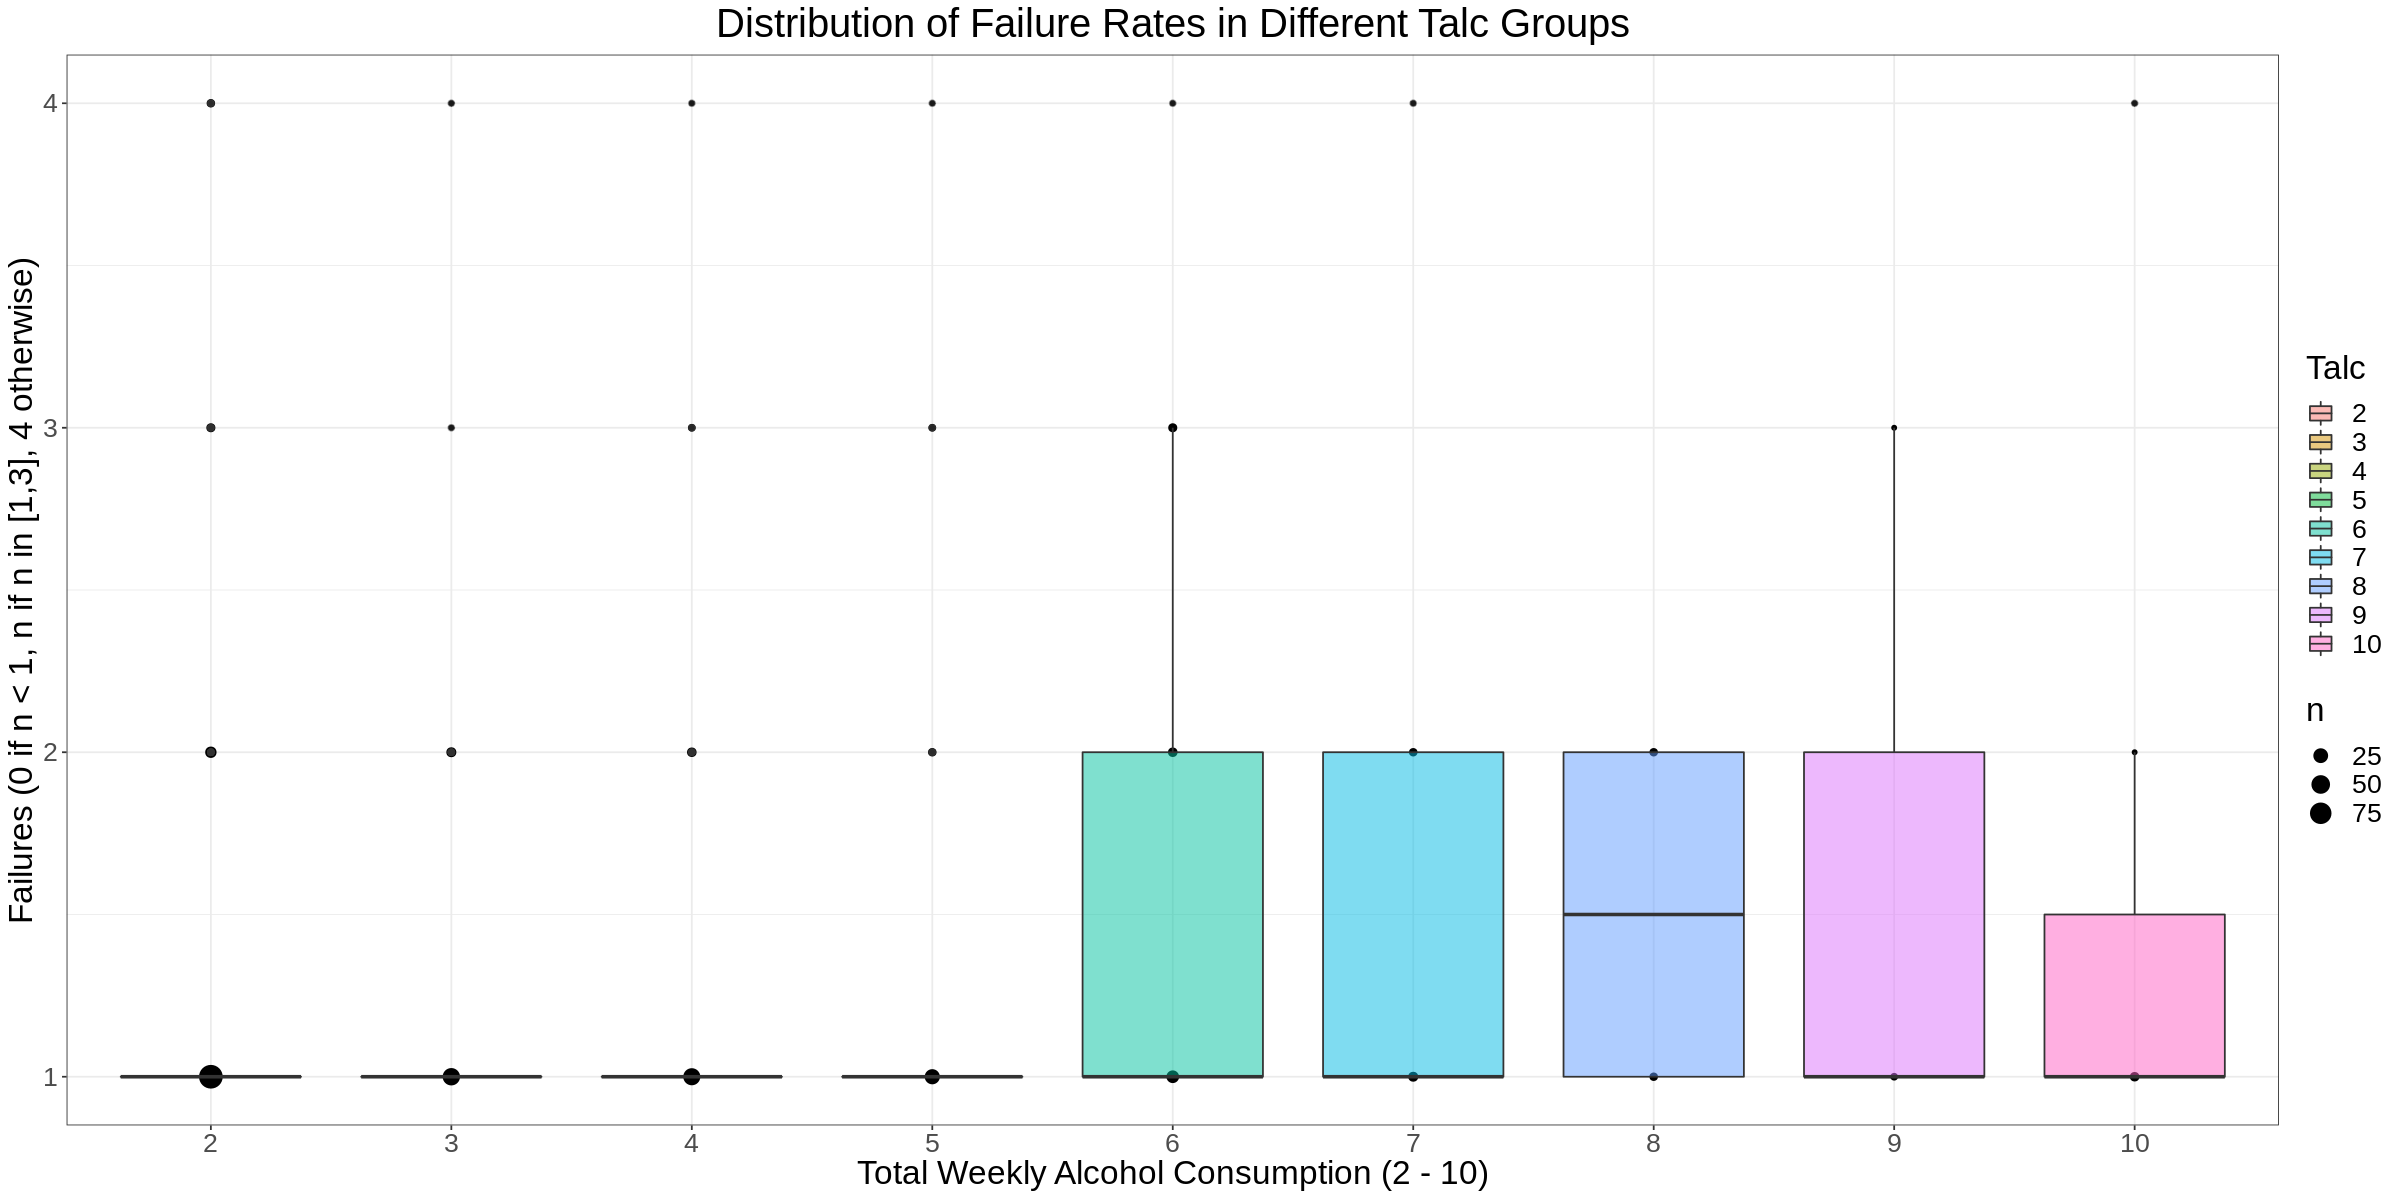

In [120]:
sac_train_failures_scatter_data <- sac_train |>
    select(Talc, failures) 

sac_train_failures_scatter_data$failures <- as.numeric(sac_train_failures_scatter_data$failures)

sac_train_failure_plot <- sac_train_failures_scatter_data |>
    ggplot() +
    geom_count(aes(x = Talc, y = failures)) +
    geom_boxplot(aes(x = Talc, y = failures, fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Failures (0 if n < 1, n if n in [1,3], 4 otherwise)",
          title = "Distribution of Failure Rates in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))

sac_train_failure_plot

It appears that higher `Talc` groups tend to also have more failures.

##### Grades Distribution 


The relationship between `Talc` and `AvgG` distribution was investigated.

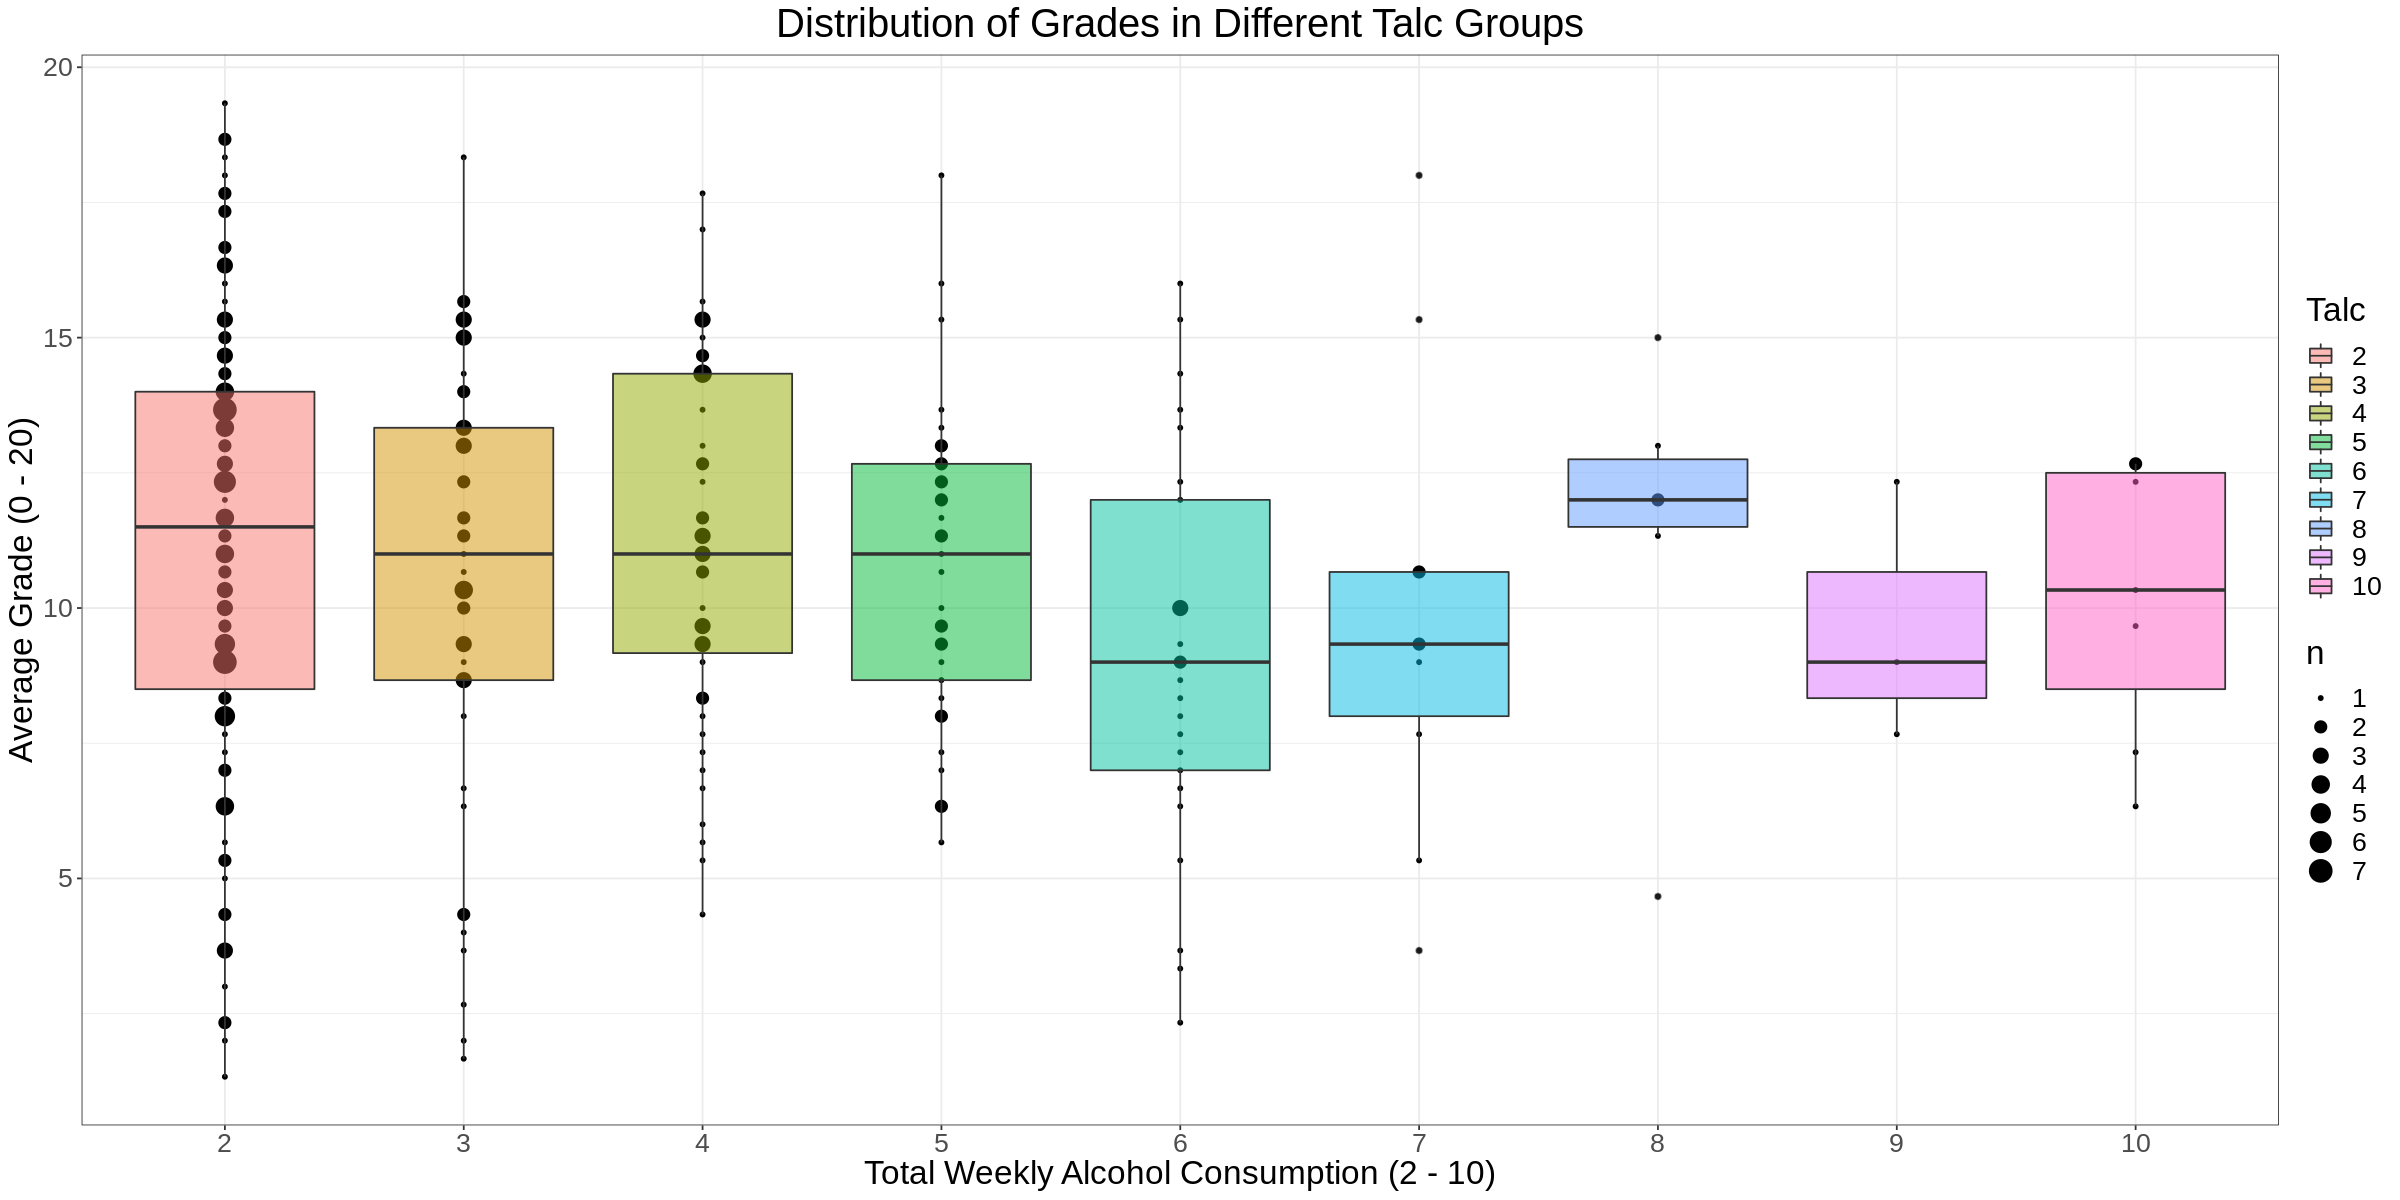

In [123]:
sac_train_avg_grades_scatter_data <- sac_train |>
    select(Talc, AvgG) 

sac_train_avg_grades_scatter <- sac_train_avg_grades_scatter_data |>
    ggplot() +
    geom_count(aes(x = Talc, y = AvgG)) +
    geom_boxplot(aes(x = Talc, y = AvgG, fill = Talc), alpha = 0.5) +
     labs(x = "Total Weekly Alcohol Consumption (2 - 10)",
          y = "Average Grade (0 - 20)",
          title = "Distribution of Grades in Different Talc Groups") +
     theme(plot.title = element_text(hjust = 0.5),
           text = element_text(size = 20))

sac_train_avg_grades_scatter

Here, it appears that students in lower `Talc` groups have slightly higher `AvgG`

In summary, the trends appear to be weakly related. However, the aim is that the combination is sufficient for classification.

***
## **Methods**
***

* Explain data analysis and what varaibles you will use
* Explain meaning of variables - all or predictive?
* Explain visualization you will complete


KNN Classification
- Data will be standardized and scaled - to prevent mixing values of different magnitudes (aka one variable overtaking analysis)
- Class variable needs to be a factor 
- You want approximately equal members in each class
- create a model specification for K-NN with model_tune() 
- Use weight_func = "rectangular"
- Set up recipe to use all other factor as predictors - preprocessing
- Fit data to training data - train the classifier
- we can balance the data sets with uc_recipe and step_upsample - but probably don't want to
- predict labels in the test set, and bind using bind_cols()
- Use metrics to judge the accuracy (class prediction == TAlc)
- Use validation set (made with 5-factor vfold of training data) to do cross-validation 


KNN Regression

KNN Strengths/Weaknesses
- Simple - good for us 
- Low assumptions - good for us as we know little about the students other than what was given
- Works well w non-linear - good for us as no knowledge of how it relates
- Works poorly with huge data set - but our data set isn't huge
- Works poorly with too many predictors - limiting to 5
- May not predict well beyond range of values inputted - good for classification 

***
## **Expected Outcomes and Significance**
***

1. What do we expect to find? 
2. What impact do these findings have?
3. What future questions could this lead to?

Use cross validation to evaluate different parameter choices 
* different values of K - choose K that gives lower RMSPE

Use RMSPE to determine if it matches or not - squared difference

## **References**

[1] Cortez, P., & Silva, A. M. G. (2008). Using data mining to predict secondary school student performance.

[2] Wei, Q. (2017). Binge drinking and academic performance, engagement, aspirations, and expectations: A longitudinal analysis among secondary school students in the COMPASS study. Health Promotion and Chronic Disease Prevention in Canada: Research, Policy and Practice, 37(11), 376.

[3] Mekonen, T., Fekadu, W., Chane, T., & Bitew, S. (2017). Problematic alcohol use among university students. Frontiers in psychiatry, 8, 86.